In [1]:
from Data import  data_processing as dp
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
from sklearn.metrics import classification_report
from AdvancedNet.lstm_analysis import analyze_lstm_performance
from sklearn.metrics import precision_score, recall_score

In [2]:
# Get all data splits at once
X_train, X_val, X_test, y_train, y_val, y_test, vectorizer = dp.get_training_validation_test_data()

In [3]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [4]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        self.dropout = nn.Dropout(0.3)  # Dropout to reduce overfitting
        
        # Define the fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # If x is already (batch_size, seq_len, input_dim), 
        # do NOT unsqueeze. If x is (batch_size, input_dim) (2D), then unsqueeze:
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch_size, 1, input_dim)

        # Pass the 3D input to the LSTM
        lstm_out, _ = self.lstm(x)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Output of the last time-step
        last_output = lstm_out[:, -1, :]
        
        # Fully connected layer
        z = self.fc(last_output)
        return z

In [6]:
# Initialize the model
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y_train))  # number of classes
model = LSTMModel(input_dim, hidden_dim, output_dim)

In [7]:
# 3. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
train_metrics = {
    'epoch_losses': [],
    'train_accuracies': [],
    'val_accuracies': []
}
# 4. Train the Model
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        #print(X_batch.shape)  # Should be (batch_size, input_dim)
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))  # Add a sequence dimension
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_accuracy = correct / total

    # Validate the model
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = (val_predicted == y_val_tensor).sum().item() / y_val_tensor.size(0)
       # Store metrics for visualization
    train_metrics['epoch_losses'].append(epoch_loss)
    train_metrics['train_accuracies'].append(train_accuracy)
    train_metrics['val_accuracies'].append(val_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10, Loss: 109.5198, Train Accuracy: 0.8124, Validation Accuracy: 0.9065
Epoch 2/10, Loss: 38.8983, Train Accuracy: 0.9380, Validation Accuracy: 0.9219
Epoch 3/10, Loss: 21.2537, Train Accuracy: 0.9636, Validation Accuracy: 0.9228
Epoch 4/10, Loss: 13.8765, Train Accuracy: 0.9779, Validation Accuracy: 0.9238
Epoch 5/10, Loss: 9.6831, Train Accuracy: 0.9860, Validation Accuracy: 0.9231
Epoch 6/10, Loss: 6.8734, Train Accuracy: 0.9915, Validation Accuracy: 0.9224
Epoch 7/10, Loss: 4.8655, Train Accuracy: 0.9944, Validation Accuracy: 0.9202
Epoch 8/10, Loss: 3.6233, Train Accuracy: 0.9972, Validation Accuracy: 0.9202
Epoch 9/10, Loss: 2.5672, Train Accuracy: 0.9984, Validation Accuracy: 0.9180
Epoch 10/10, Loss: 1.8707, Train Accuracy: 0.9990, Validation Accuracy: 0.9166


In [9]:
# Final evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    test_predictions = predicted.cpu().numpy()
    test_targets = y_test_tensor.cpu().numpy()
    
    test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    test_precision = precision_score(test_targets, test_predictions, average='weighted')
    test_recall = recall_score(test_targets, test_predictions, average='weighted')

print("\nFinal Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")



Final Test Metrics:
Accuracy: 0.9200
Precision: 0.9207
Recall: 0.9200


In [10]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, predicted.cpu().numpy()))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2078
           1       0.90      0.94      0.92      2082

    accuracy                           0.92      4160
   macro avg       0.92      0.92      0.92      4160
weighted avg       0.92      0.92      0.92      4160


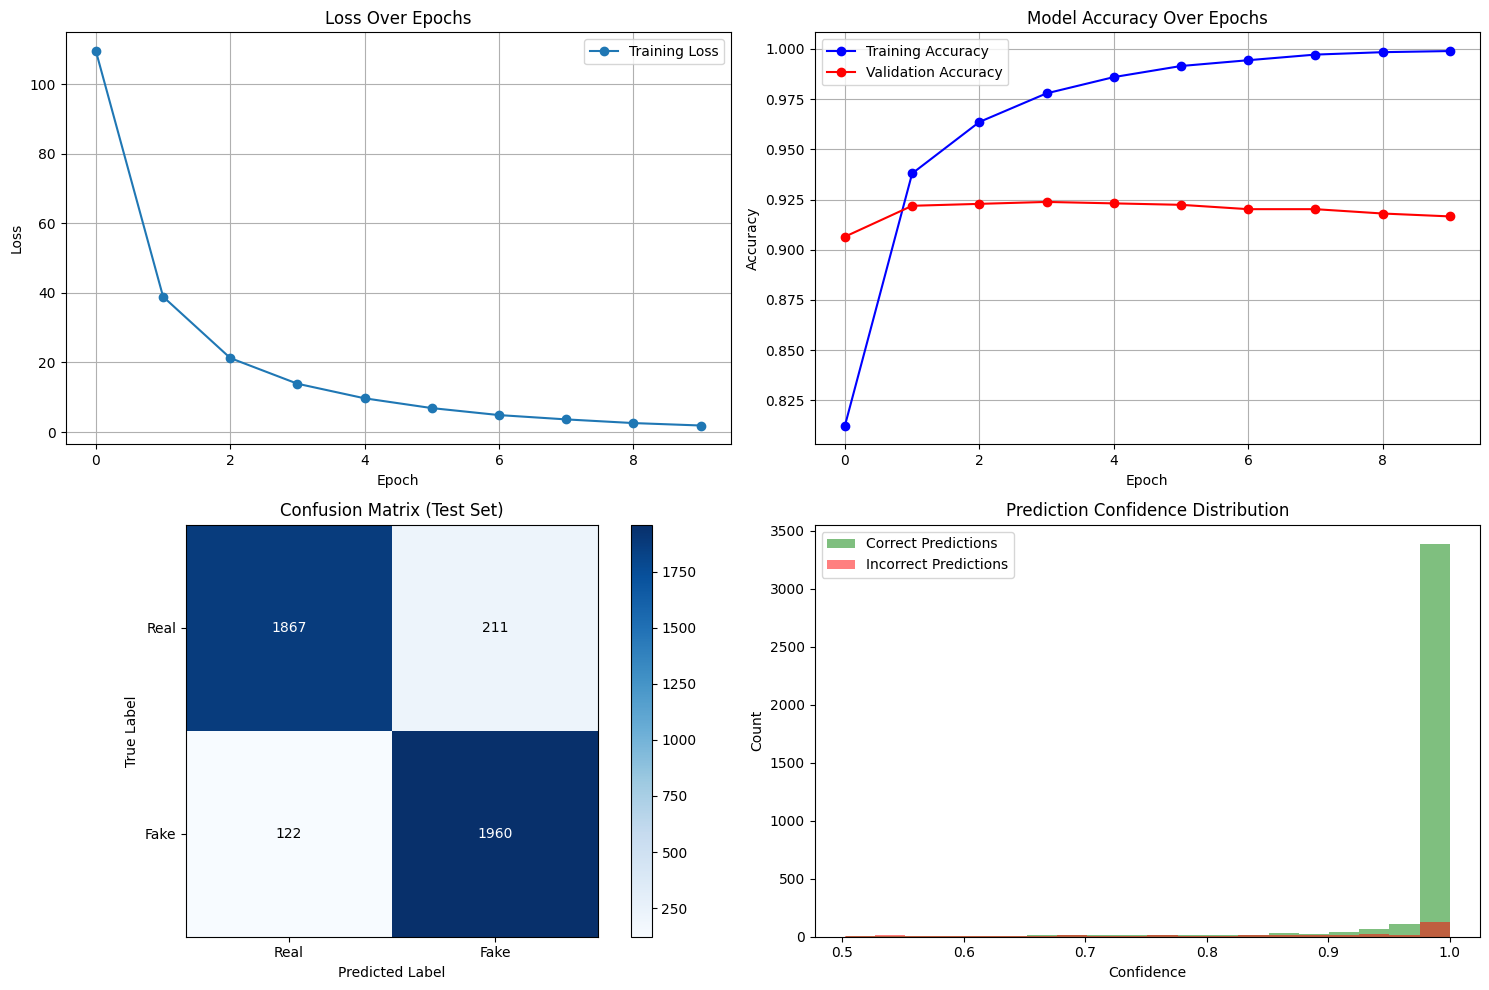


=== Model Performance Summary ===

Confusion Matrix:
                  Predicted
                  Real    Fake
Actual Real:     1867     211
      Fake:     122     1960

Final Test Accuracy: 0.9200
Average Prediction Confidence: 0.9715


In [11]:
analyze_lstm_performance(model, train_metrics, X_test_tensor, y_test_tensor, X_val_tensor, y_val_tensor)